# Analysing NASA Sunspot Data

## Preparing the Data

We analyse NASA sunspot data in the accompanied .dat file with `pandas`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Read first line of the data file to examine its contents.
with open("omni2_all_years.dat") as f:
    print(f.readline())

1963   1  0 1771 99 99 999 999 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 9999999. 999.9 9999. 999.9 999.9 9.999 99.99 9999999. 999.9 9999. 999.9 999.9 9.999 999.99 999.99 999.9  7  33    -6  119 999999.99 99999.99 99999.99 99999.99 99999.99 99999.99  0   3 999.9 999.9 99999 99999 99.9



The above is one data entry in the data file. We shall not be using all of the fields, instead focusing on 
* Columns 0, 1 and 2 giving the Year, Day of Year (DOY) and hour of each measurement
* Column 39 is the "sunspot number" ($R$)
* Column 40 is the "Dst index"; an hourly measure of the sun's magnetic activity as measured from the Earth's surface (measured in nano Tesla $\text{nT}$)
* Column 50 is the "$\text{F10.7}$" index; the radio flux at $\text{10.7cm}$ i.e. the brightness of the sun at that wavelenth (in solar flux units $\text{sfu}$)

We use the `pandas` functionality to read in the data

In [3]:
df = pd.read_csv("omni2_all_years.dat", 
                 delim_whitespace = True,
                 usecols = [0, 1, 2, 39, 40, 50],
                 names = ["Year", "DoY", "Hour", "R", "Dst", "F10.7"])

df.head(10)

,Year,DoY,Hour,R,Dst,F10.7
0,1963,1,0,33,-6,999.9
1,1963,1,1,33,-5,999.9
2,1963,1,2,33,-5,999.9
3,1963,1,3,33,-3,999.9
4,1963,1,4,33,-3,999.9
5,1963,1,5,33,-6,999.9
6,1963,1,6,33,-8,999.9
7,1963,1,7,33,-9,999.9
8,1963,1,8,33,-6,999.9
9,1963,1,9,33,-2,999.9


We now combine the first three columns to create a `pandas.DatetimeIndex` object (based on Python's `datetime` object). Once the index is created, we no longer require those columns and so drop them from the `DataFrame`:

In [4]:
df.index = pd.to_datetime(df["Year"] * 100000 + df["DoY"] * 100 + df["Hour"], format="%Y%j%H")
df = df.drop(columns = ["Year", "DoY", "Hour"])
df.head(10)

,R,Dst,F10.7
1963-01-01 00:00:00,33,-6,999.9
1963-01-01 01:00:00,33,-5,999.9
1963-01-01 02:00:00,33,-5,999.9
1963-01-01 03:00:00,33,-3,999.9
1963-01-01 04:00:00,33,-3,999.9
1963-01-01 05:00:00,33,-6,999.9
1963-01-01 06:00:00,33,-8,999.9
1963-01-01 07:00:00,33,-9,999.9
1963-01-01 08:00:00,33,-6,999.9
1963-01-01 09:00:00,33,-2,999.9


In this data set, missing numbers have been replaced with 9's. We replace them with `NaN` in the `DataFrame`.

In [5]:
df = df.replace({"R": 999, 
                "DST": 99999,
                "F10.7": 999.9}, np.NaN)
df.head(10)

,R,Dst,F10.7
1963-01-01 00:00:00,33.0,-6,NaN
1963-01-01 01:00:00,33.0,-5,NaN
1963-01-01 02:00:00,33.0,-5,NaN
1963-01-01 03:00:00,33.0,-3,NaN
1963-01-01 04:00:00,33.0,-3,NaN
1963-01-01 05:00:00,33.0,-6,NaN
1963-01-01 06:00:00,33.0,-8,NaN
1963-01-01 07:00:00,33.0,-9,NaN
1963-01-01 08:00:00,33.0,-6,NaN
1963-01-01 09:00:00,33.0,-2,NaN


We first check that there are no missing rows in the `DataFrame`. The number of entries is given by

In [6]:
print("DataFrame shape:", df.shape)

DataFrame shape: (508440, 3)


Comparing this to the number of hours between the first and last timestamps,

In [7]:
dt = df.index[-1] - df.index[0]
print("Number of hours between start and end dates: ", dt.total_seconds()/3600 + 1)

Number of hours between start and end dates:  508440.0


we see that we do indeed have the expected number of data points.
***

## Visualising the Time Series

We now visualise the time series with plots:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f796cb6da00>,
      dtype=object)

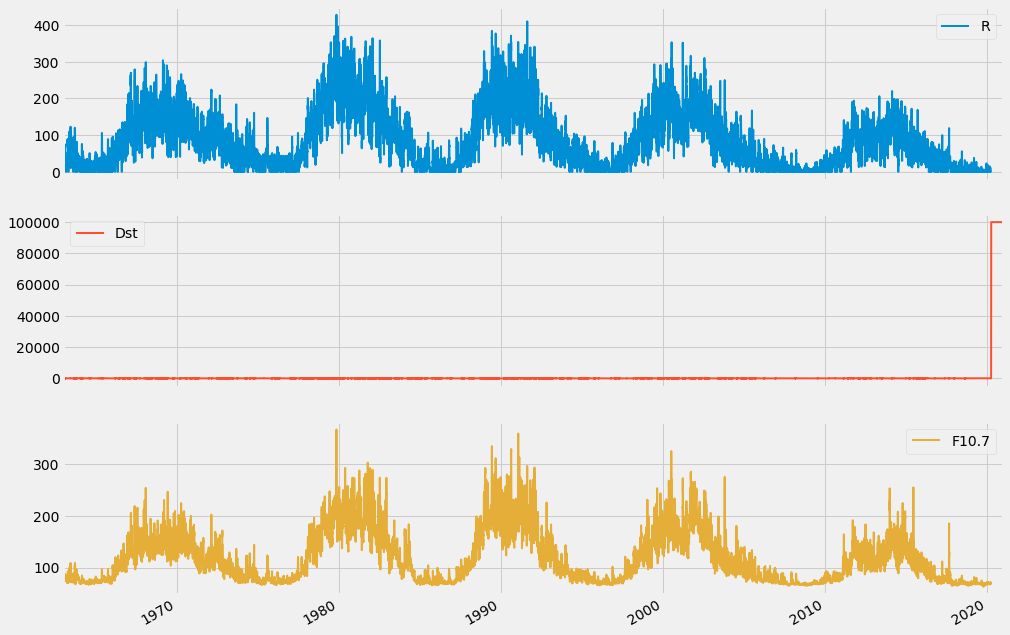

In [8]:
df.plot(subplots = True, figsize = (15, 12), linewidth = 2)

The "R" and "F10.7" fields look nicely correlated. We shall try plotting just those two on the same plot. Note that their units are different and so it is only by chance that they both fall in the same order of magnitude.

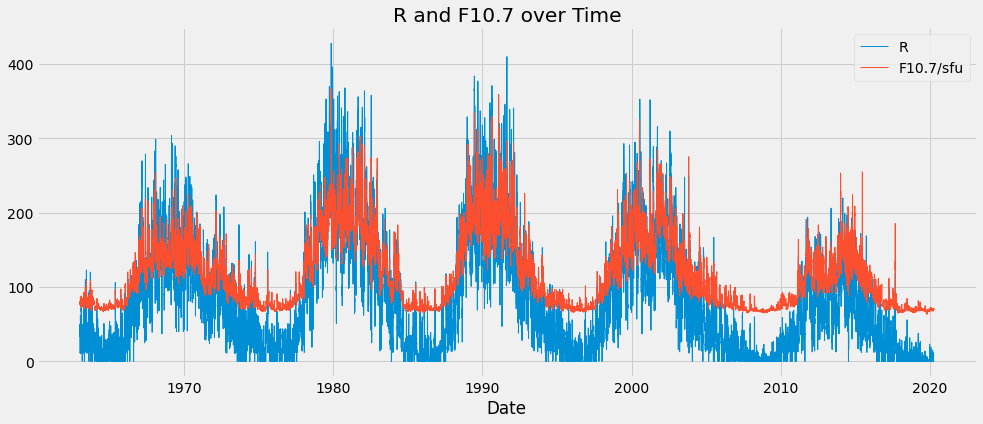

In [9]:
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(df["R"], linewidth = 1, label = 'R')
ax.plot(df["F10.7"], linewidth = 1, label = 'F10.7/sfu')
ax.set_title('R and F10.7 over Time')
ax.set_xlabel('Date')
ax.legend()

As one last example, we plot the "F10.7" and "Dst" as a function of sunspot number "R":

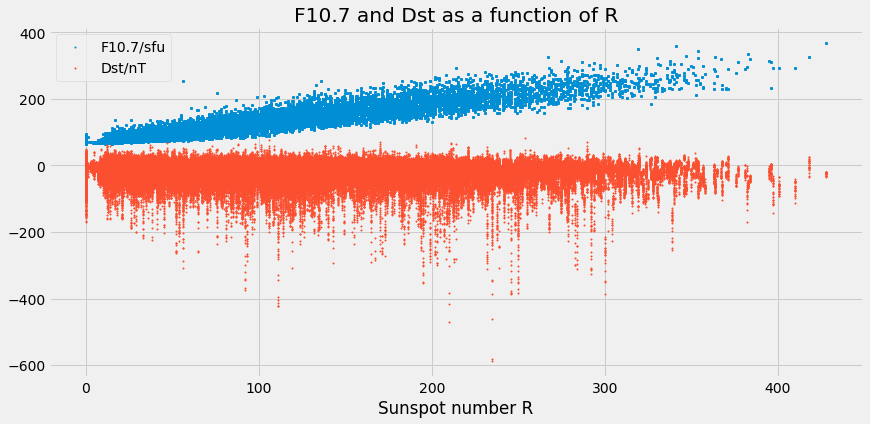

In [10]:
fig, ax = plt.subplots(figsize = (13,6))
ax.scatter(df["R"], df["F10.7"], s = 2, label = 'F10.7/sfu')
ax.scatter(df["R"], df["Dst"], s = 2, label = 'Dst/nT')
ax.set_title('F10.7 and Dst as a function of R')
ax.set_xlabel('Sunspot number R')
ax.legend()

***

## Resampling, rolling calcualations and differencing

### Resampling

We see that there is a lot of noise in the data. We can reduce this by resampling over longer timescales than the hourly samples. `pandas` offers a convenient `resampling()` method to reduce the data cadence:

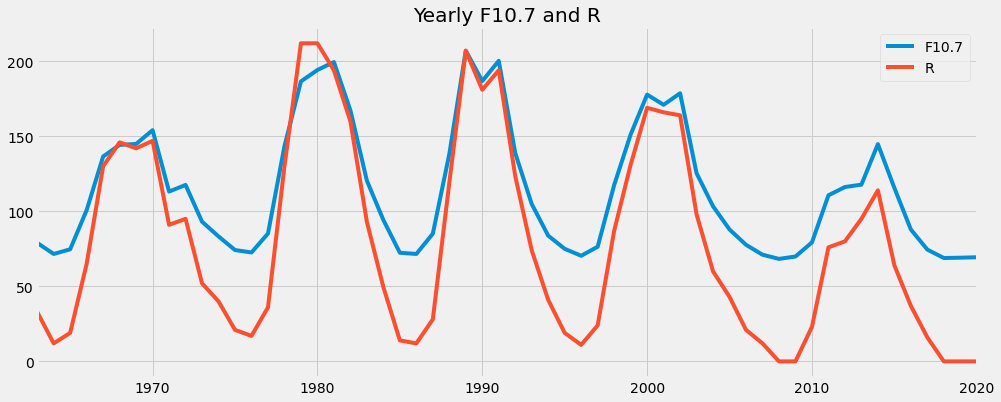

In [11]:
# Resample, considering only the median yearly values.
df[["F10.7", "R"]].resample("1y").median().plot(title = 'Yearly F10.7 and R', figsize = (15, 6))

In the code above, `resample()` returns a year-based (specified by `"1y"`) `resampler` object. We then pass this to `resampler.median}()` to obtain a new year-based time series which is plotted as usual. The types of the intermediate temporaries may be examined as follows:

In [12]:
print(type(df[["F10.7"]].resample("1y")))
print(type(df[["F10.7"]].resample("1y").median()))

<class 'pandas.core.resample.DatetimeIndexResampler'>
<class 'pandas.core.frame.DataFrame'>


### Rolling Calculations

Similar to resamping, __rolling window__ calculations also reduce the cadence of the dataset. However, rather than performing windows on batches of data, calculations are instead performed on a rolling window of a given width about each datapoint.

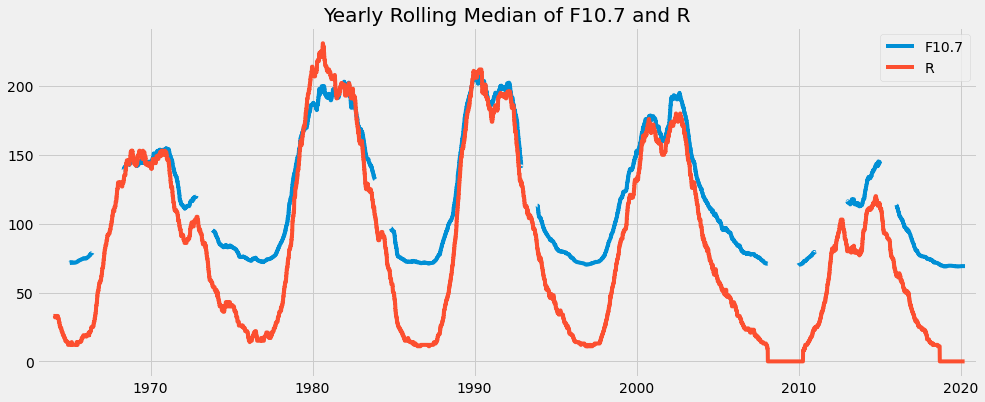

In [13]:
df[["F10.7", "R"]].rolling(24 * 365).median().plot(title = 'Yearly Rolling Median of F10.7 and R', figsize = (15, 6))

The argument of `rolling()` is the number of points in the rolling window; the larger the argument, the greater the loss of detail. Note that `resample()` takes a duration as an argument. We see that the $\text{F10.7}$ has some data missing; no gaps are allowed when each window is calculated. This behaviour can be modified by an optional `min_periods()` argument.

## Differencing

A _stationary_ time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends or seasonality are not stationary. By contrast, a white noise series is a stationary series; it looks pretty much the same regardless of when it is observed.

In general, a stationary time series has no predictable long-term patterns. Stationary time series tend to be roughly horizontal (although some cyclic behaviour is allowed), with constant variance. Accordingly, they are the easiest type of time series to handle.

For time series that are not staitionary, it is common to apply transformations to the data that make them (approximately) stationary. One way to do this is by __differencing__---plotting the differerence between consecutive observations. 

Whilst transformations such as logarithms can help stabilise the variance of the time series, differencing can help stabilies the mean of the time series by removing changes in the level of the time series and isolating trends and seasonality.

`pandas` offers the following tool to isolate the periodic signal:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f795856d760>,
      dtype=object)

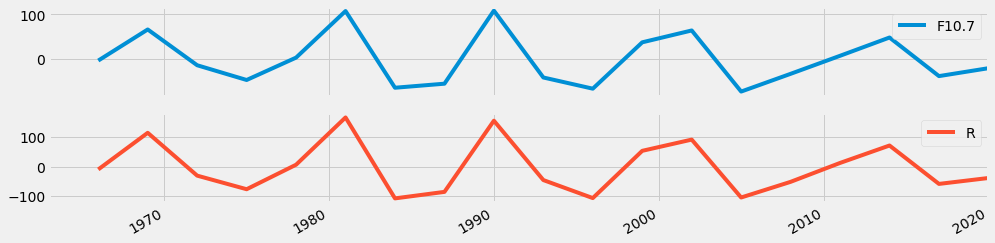

In [14]:
df[["F10.7", "R"]].resample("3y").median().diff().plot(subplots = True, figsize = (15, 4))

***

## Identifying Periodicity and Correlation

Even by eye, the last two plots shows a roughly 10-year cycle in the $R$ and $\text{F10.7}$ data. One way of identifying this periodicity is by reading the autocorrelation plot (accessible in `pandas` by `pandas.plotting.autocorrelation_plot()`)

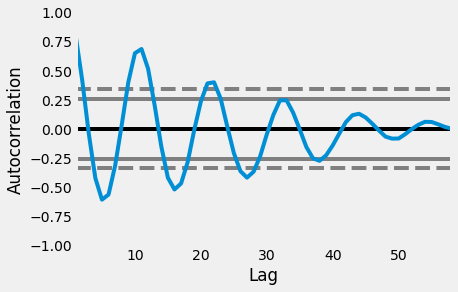

In [15]:
pd.plotting.autocorrelation_plot(df["R"].resample("1y").median())

This produces an _autocorrelation plot;_ the correlation of the time series with itself as a function of lag times (in years). Above, we applied it to the down-sampled $R$ time series to make the computations much faster. The peak at 11 years reflects the well-known solar activity cycle.

We now return to the Dst index and study if there is any relation to $R$. Recall that Dst indicates the level of geomagnetic activity whilst $R$ measures solar activity. One could try to smooth the Dst series to reduce the noise and and try to correlate this with $R$. However, this turns out to not be fruitful.

Instead, it is useful to know that variations in Dst occur in discrete events called _geomagnetic storms_ in which the Dst abruptly drops below $\text{0nT}$ and takes some hours or days to recover back to $\text{0nT}$. We shall classify large geomagnetic storms as those that drop below $-\text{100nT}$.

We can count the number of occurrences of large geomagnetic storms by filtering:

In [16]:
Dst_count = df["Dst"].where(df["Dst"] < -100).resample("1y").count()
Dst_count = Dst_count.reindex(df.index, method = "bfill")

The second line above imposes that the new down-sampled `DataFrame` uses the same index as the original, unfiltered, `DataFrame`. We now append this back to `df` (rather than the down-sampled `df`) and plot it against $R$.

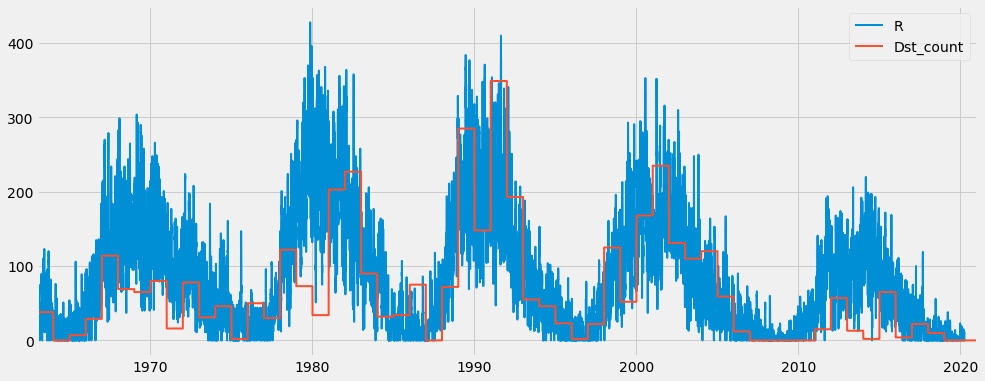

In [17]:
df["Dst_count"] = Dst_count
df.plot(y = ["R", "Dst_count"], figsize = (15, 6), linewidth = 2)

The plot above suggests some degree of correlation between high sunspot numbers and the occurrence rate of _large_ geomagnetic storms. However, there is a lot more variation in the storm rate---lots of sunspots do not guarantee lots of large geomagnetic storms and large geomagnetic storms can still occur when there are comparatively few sunspots.

***

## Splitting and Stacking Cycles 

We can split the time series into cycles and stack them on top of each other to compare them. We first downsample to a daily rate to improve the runtime and makes the plots a bit clearer.

In [18]:
# List of solar cycle start dates
minima = ["1964-10", "1976-03", "1986-09", "1996-08", "2008-12", "2019-12"]

# Downsample to daily rates
df_daily = df.resample("1D").mean()


def split_into_cycles(df):
    """
    Returns a list of dataframes, one for each solar cycle
    """
    cycles = []
    # Split by solar cycle
    for start, end in zip(minima[0:-1], minima[1:]):
        
        # Get the data in the current range mimina[i]---mimina[i+1]
        cycle = df[start:end]
        
        # Convert from dates to days from the start of this minimum
        cycle.index = (cycle.index - cycle.index[0]).days
        
        # Extend so that each cycle lasts a full 5000 days (filled with nan)
        # Note: 11 years = 4015 days; we allow for some leeway.
        ix = pd.Int64Index(np.arange(0,5000))
        cycle.reindex(ix)
        
        cycles.append(cycle)
    return cycles

cycles = split_into_cycles(df_daily)

The list `cycles` now contains five `DataFrames`, each containing the data of one solar cycle. We now plot all fives cycles on the same plot using `Matplotlib`:

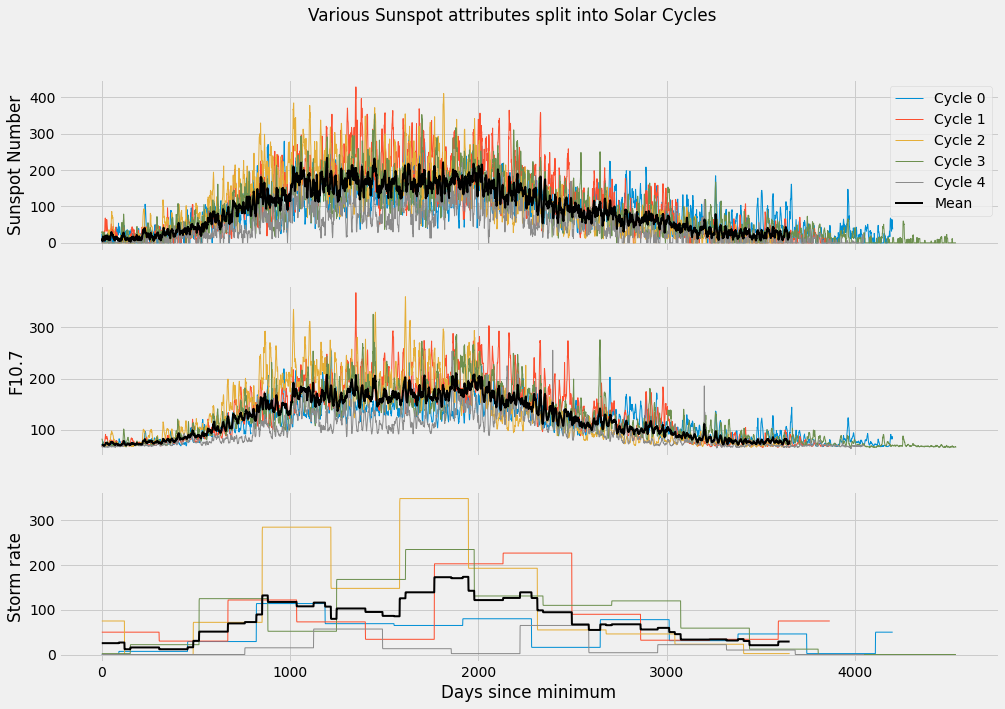

In [19]:
# sharex = True ensures all plots share the same x-axis
# matplotlib.subplots() returns an instance of Figure and an array of Axes objects.
fig, axes = plt.subplots(3, 1, figsize = (15,10), sharex = True)

# Iterate over the cycles and add their data to their respective plots.
# cycles is a list of DataFrames of the solar cycles.
for i, cycle in enumerate(cycles):
    # ax = axes[i] specifies which plot (which axis) to add to.
    cycle["R"].plot(ax = axes[0], label = f"Cycle {i}", linewidth = 1)
    cycle["F10.7"].plot(ax = axes[1], linewidth = 1)
    cycle["Dst_count"].plot(ax = axes[2], linewidth = 1)

# Add plots of means of the cycles to each figure.
# We construct a new DataFrame containing the means of the respective fields of the five cycles.
# sum(cycles) produces a new DataFrame (with the same fields as df "R", "F10.7" etc.) 
# whose [i][j] element is given by the sum of the [i][j] elements of the individual DataFrames.
# We then specify which Series in the DataFrame to focus on and divide its elemnts by N_cyles
# to obtain a time series of the means of the five cycles.
N_cycles = len(cycles)
(sum(cycles)["R"]/N_cycles).plot(ax=axes[0], color='k', label="Mean", linewidth = 2)
(sum(cycles)["F10.7"]/N_cycles).plot(ax=axes[1], color= 'k', linewidth = 2)
(sum(cycles)["Dst_count"]/N_cycles).plot(ax=axes[2], color= 'k', linewidth = 2)

fig.suptitle('Various Sunspot attributes split into Solar Cycles')
axes[0].legend()
axes[0].set_ylabel("Sunspot Number")
axes[1].set_ylabel("F10.7")
axes[2].set_ylabel("Storm rate")
axes[2].set_xlabel("Days since minimum")

plt.show()

The resulting plots are examples of _superposed epoch analyses_ which are useful for identifying periodicities in the noisy time series. We see, for example, that the most recent cycle (`Cycle 4`) is consistently below the mean of the five cycles in both $R$ and $\text{F10.7}$. Although more difficult to see, the storm rate `Dst_count` is also consistently below the mean.